# Picocoder
_A Raspberry Pi Pico microcode glitcher_

## Connection
We connect with the Pi Pico and setup some glitching options.

In [1]:
%matplotlib widget

PORT = '/dev/ttyACM1'
BAUD = 115200

import struct
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from importlib import reload # for debugging

import glitch_utils
from glitch_utils import GlitchResult
glitch_utils = reload(glitch_utils)

try:
	del glitcher
	del gc
except:
	pass
glitcher = glitch_utils.GlitchyMcGlitchFace(PORT, BAUD)
gc = glitch_utils.GlitchController(groups=[r.name for r in GlitchResult], parameters=['ext_offset', 'width'])
gc.set_range('ext_offset', 1, 10)
gc.set_range('width', 1, 10)

## Estimating glitch external offset
We obtain an estimate (in us) of the wait time between trigger and glitch.

In [2]:
glitcher.s.write(glitch_utils.P_CMD_ESTIMATE_OFFSET)
ret_data = glitcher.s.read(4)
ext_offset = struct.unpack("<i", ret_data)[0]
gc.set_range('ext_offset', ext_offset-10, ext_offset+10)
print(f"Estimated offset: {ext_offset}")

Estimated offset: 129


## Measure UART delay
This command is used to measure (externally) the time it takes for the Pico to
detect data on the UART RX pin and to start processing it. <br>
The debug pin (GPIO 16, shown blue) is toggled when the Pico detects data.

![Oscilloscope capture](../firmware/inject_v2/img/fast_response_time_busy_wait_on_UART_with_timeout.png)

In [3]:
glitcher.s.write(glitch_utils.P_CMD_UART_DEBUG_TOGGLE)
ret_data = glitcher.s.read(4)
result = (bool)(struct.unpack("<I", ret_data)[0])
print(f"Found trigger: {result}")

Found trigger: True


## Glitch loop

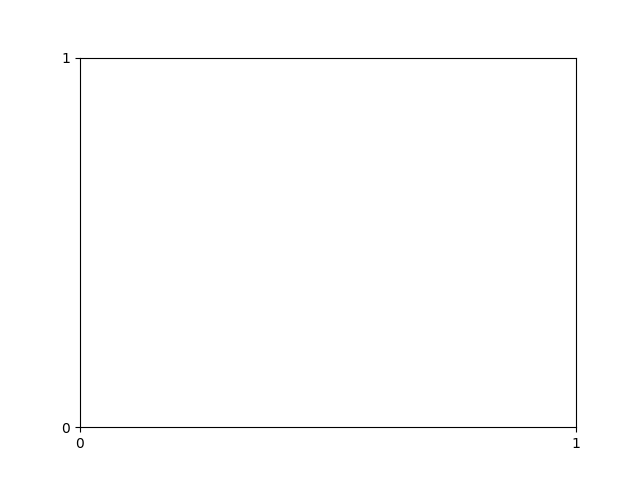

In [4]:
# NOTE This figure must be generated in a different cell than the one that calls the plot function
#	   Otherwise the plot will not be displayed until the cell is done executing (no live plot)
fig, ax = plt.subplots()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [5]:
try:
	for glitch_setting in gc.rand_glitch_values():
		read_result, read_data = glitcher.glitch_mul(glitch_setting, expected=0x1337)
		gc.add_result(glitch_setting, read_result)
		if read_result == GlitchResult.SUCCESS:
			print(f'Got success data: 0x{read_data.hex()}')
		if read_result == GlitchResult.WEIRD:
			print(f'Got weird response: 0x{read_data.hex()}')
		if read_result == GlitchResult.BROKEN:
			print(f'The target is in broken state: {glitch_utils.RESULT_NAMES[read_data]} (0x{int.from_bytes(read_data):x})')
		ax.plot(*glitch_setting, glitch_utils.result_to_marker(read_result))
		fig.canvas.draw() # Guarantees live update of the plot whenever a new point is added
except KeyboardInterrupt:
	pass # Gentle stop, otherwise the plot might be empty